http://repositorium.sdum.uminho.pt/bitstream/1822/30994/1/dss-v3.pdf

In [1]:
#need to install lightgbm from anacondra prompt

In [2]:
#Data Preparation
#We will now import some required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import auc, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
#Loading the dataset
dataset = pd.read_csv('bank-additional-full_copy.csv',delimiter=";")
dataset = dataset.drop(['duration'], axis=1)
dataset.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [7]:
dataset.describe()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 20 columns):
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
y                 41188 non-null object
dtypes: float64(5), int64(4), object(11)
memory usage: 6.3+ MB


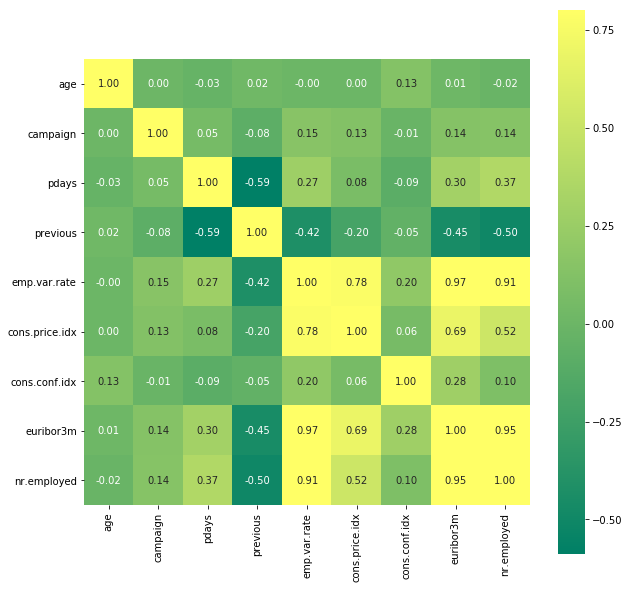

In [9]:
corrmat = dataset.corr()
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corrmat, vmax=.8, square=True, annot=True, fmt='.2f', cmap = "summer")
plt.show()

In [10]:
# Check for null values. 
dataset.isnull().sum().sort_values(ascending=False)

y                 0
nr.employed       0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
age               0
dtype: int64

In [11]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
 
features = []; categorical_features = []
num_of_columns = dataset.shape[1]
 
for i in range(0, num_of_columns):
 column_name = dataset.columns[i]
 column_type = dataset[column_name].dtypes
 
 if i != num_of_columns - 1: #skip target
  features.append(column_name)
 
 if column_type == 'object':
  le.fit(dataset[column_name])
  feature_classes = list(le.classes_)
  encoded_feature = le.transform(dataset[column_name])
  dataset[column_name] = pd.DataFrame(encoded_feature)
 
  if i != num_of_columns - 1: #skip target
   categorical_features.append(column_name)

In [12]:
# splitting data
X = dataset.drop(['y'], axis=1)
y = dataset['y']

In [21]:
#Splitting the data into Training Set and Test Set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=20)
X_train.shape

(35009, 19)

In [22]:
from sklearn.model_selection import GridSearchCV
estimator = lgb.LGBMClassifier(learning_rate = 0.125, metric = 'l1', 
                        n_estimators = 20, num_leaves = 38)


param_grid = {
    'n_estimators': [x for x in range(20, 36, 2)],
    'learning_rate': [0.10, 0.125, 0.15, 0.175, 0.2]}
gridsearch = GridSearchCV(estimator, param_grid)

gridsearch.fit(X_train, y_train,
        eval_set = [(X_test, y_test)],
        eval_metric = ['auc', 'binary_logloss'],
        early_stopping_rounds = 5)

C:\Users\barba\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


[1]	valid_0's auc: 0.779	valid_0's binary_logloss: 0.329385	valid_0's l1: 0.194558
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.779639	valid_0's binary_logloss: 0.317313	valid_0's l1: 0.190466
[3]	valid_0's auc: 0.783628	valid_0's binary_logloss: 0.308778	valid_0's l1: 0.186766
[4]	valid_0's auc: 0.785116	valid_0's binary_logloss: 0.302202	valid_0's l1: 0.183437
[5]	valid_0's auc: 0.784259	valid_0's binary_logloss: 0.297357	valid_0's l1: 0.180514
[6]	valid_0's auc: 0.787061	valid_0's binary_logloss: 0.293159	valid_0's l1: 0.177789
[7]	valid_0's auc: 0.787917	valid_0's binary_logloss: 0.289843	valid_0's l1: 0.175271
[8]	valid_0's auc: 0.788574	valid_0's binary_logloss: 0.28715	valid_0's l1: 0.173064
[9]	valid_0's auc: 0.791175	valid_0's binary_logloss: 0.284981	valid_0's l1: 0.171133
[10]	valid_0's auc: 0.788359	valid_0's binary_logloss: 0.283374	valid_0's l1: 0.169377
[11]	valid_0's auc: 0.78793	valid_0's binary_logloss: 0.281902	valid_0's l1: 0.167

[1]	valid_0's auc: 0.778288	valid_0's binary_logloss: 0.329011	valid_0's l1: 0.194609
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.783096	valid_0's binary_logloss: 0.316444	valid_0's l1: 0.190421
[3]	valid_0's auc: 0.783501	valid_0's binary_logloss: 0.307364	valid_0's l1: 0.186668
[4]	valid_0's auc: 0.785722	valid_0's binary_logloss: 0.300645	valid_0's l1: 0.183311
[5]	valid_0's auc: 0.785817	valid_0's binary_logloss: 0.295473	valid_0's l1: 0.180326
[6]	valid_0's auc: 0.786667	valid_0's binary_logloss: 0.291124	valid_0's l1: 0.17753
[7]	valid_0's auc: 0.787444	valid_0's binary_logloss: 0.287901	valid_0's l1: 0.175077
[8]	valid_0's auc: 0.788193	valid_0's binary_logloss: 0.285419	valid_0's l1: 0.172874
[9]	valid_0's auc: 0.789117	valid_0's binary_logloss: 0.283175	valid_0's l1: 0.170858
[10]	valid_0's auc: 0.789841	valid_0's binary_logloss: 0.281238	valid_0's l1: 0.168935
[11]	valid_0's auc: 0.789826	valid_0's binary_logloss: 0.279588	valid_0's l1: 0

[1]	valid_0's auc: 0.774197	valid_0's binary_logloss: 0.329345	valid_0's l1: 0.194698
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.774639	valid_0's binary_logloss: 0.317183	valid_0's l1: 0.19069
[3]	valid_0's auc: 0.777569	valid_0's binary_logloss: 0.308226	valid_0's l1: 0.187008
[4]	valid_0's auc: 0.779116	valid_0's binary_logloss: 0.301556	valid_0's l1: 0.183709
[5]	valid_0's auc: 0.78077	valid_0's binary_logloss: 0.2967	valid_0's l1: 0.180853
[6]	valid_0's auc: 0.785048	valid_0's binary_logloss: 0.292508	valid_0's l1: 0.178129
[7]	valid_0's auc: 0.785235	valid_0's binary_logloss: 0.289244	valid_0's l1: 0.175718
[8]	valid_0's auc: 0.78531	valid_0's binary_logloss: 0.286719	valid_0's l1: 0.173549
[9]	valid_0's auc: 0.786102	valid_0's binary_logloss: 0.284511	valid_0's l1: 0.171503
[10]	valid_0's auc: 0.78497	valid_0's binary_logloss: 0.282974	valid_0's l1: 0.169759
[11]	valid_0's auc: 0.786447	valid_0's binary_logloss: 0.281472	valid_0's l1: 0.1681

[1]	valid_0's auc: 0.779	valid_0's binary_logloss: 0.329385	valid_0's l1: 0.194558
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.779639	valid_0's binary_logloss: 0.317313	valid_0's l1: 0.190466
[3]	valid_0's auc: 0.783628	valid_0's binary_logloss: 0.308778	valid_0's l1: 0.186766
[4]	valid_0's auc: 0.785116	valid_0's binary_logloss: 0.302202	valid_0's l1: 0.183437
[5]	valid_0's auc: 0.784259	valid_0's binary_logloss: 0.297357	valid_0's l1: 0.180514
[6]	valid_0's auc: 0.787061	valid_0's binary_logloss: 0.293159	valid_0's l1: 0.177789
[7]	valid_0's auc: 0.787917	valid_0's binary_logloss: 0.289843	valid_0's l1: 0.175271
[8]	valid_0's auc: 0.788574	valid_0's binary_logloss: 0.28715	valid_0's l1: 0.173064
[9]	valid_0's auc: 0.791175	valid_0's binary_logloss: 0.284981	valid_0's l1: 0.171133
[10]	valid_0's auc: 0.788359	valid_0's binary_logloss: 0.283374	valid_0's l1: 0.169377
[11]	valid_0's auc: 0.78793	valid_0's binary_logloss: 0.281902	valid_0's l1: 0.167

[1]	valid_0's auc: 0.778288	valid_0's binary_logloss: 0.329011	valid_0's l1: 0.194609
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.783096	valid_0's binary_logloss: 0.316444	valid_0's l1: 0.190421
[3]	valid_0's auc: 0.783501	valid_0's binary_logloss: 0.307364	valid_0's l1: 0.186668
[4]	valid_0's auc: 0.785722	valid_0's binary_logloss: 0.300645	valid_0's l1: 0.183311
[5]	valid_0's auc: 0.785817	valid_0's binary_logloss: 0.295473	valid_0's l1: 0.180326
[6]	valid_0's auc: 0.786667	valid_0's binary_logloss: 0.291124	valid_0's l1: 0.17753
[7]	valid_0's auc: 0.787444	valid_0's binary_logloss: 0.287901	valid_0's l1: 0.175077
[8]	valid_0's auc: 0.788193	valid_0's binary_logloss: 0.285419	valid_0's l1: 0.172874
[9]	valid_0's auc: 0.789117	valid_0's binary_logloss: 0.283175	valid_0's l1: 0.170858
[10]	valid_0's auc: 0.789841	valid_0's binary_logloss: 0.281238	valid_0's l1: 0.168935
[11]	valid_0's auc: 0.789826	valid_0's binary_logloss: 0.279588	valid_0's l1: 0

[1]	valid_0's auc: 0.774197	valid_0's binary_logloss: 0.324687	valid_0's l1: 0.193547
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.777832	valid_0's binary_logloss: 0.310906	valid_0's l1: 0.188535
[3]	valid_0's auc: 0.779013	valid_0's binary_logloss: 0.302119	valid_0's l1: 0.184327
[4]	valid_0's auc: 0.781272	valid_0's binary_logloss: 0.295703	valid_0's l1: 0.180639
[5]	valid_0's auc: 0.784012	valid_0's binary_logloss: 0.290842	valid_0's l1: 0.177309
[6]	valid_0's auc: 0.78415	valid_0's binary_logloss: 0.287354	valid_0's l1: 0.17438
[7]	valid_0's auc: 0.786059	valid_0's binary_logloss: 0.284496	valid_0's l1: 0.171801
[8]	valid_0's auc: 0.784485	valid_0's binary_logloss: 0.282589	valid_0's l1: 0.169656
[9]	valid_0's auc: 0.786894	valid_0's binary_logloss: 0.280821	valid_0's l1: 0.167701
[10]	valid_0's auc: 0.787616	valid_0's binary_logloss: 0.279534	valid_0's l1: 0.16591
[11]	valid_0's auc: 0.78811	valid_0's binary_logloss: 0.278641	valid_0's l1: 0.16

[1]	valid_0's auc: 0.779	valid_0's binary_logloss: 0.324703	valid_0's l1: 0.193358
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.779552	valid_0's binary_logloss: 0.311533	valid_0's l1: 0.188404
[3]	valid_0's auc: 0.78429	valid_0's binary_logloss: 0.30264	valid_0's l1: 0.183989
[4]	valid_0's auc: 0.783664	valid_0's binary_logloss: 0.296475	valid_0's l1: 0.180172
[5]	valid_0's auc: 0.785666	valid_0's binary_logloss: 0.291873	valid_0's l1: 0.176974
[6]	valid_0's auc: 0.786353	valid_0's binary_logloss: 0.288034	valid_0's l1: 0.174016
[7]	valid_0's auc: 0.788319	valid_0's binary_logloss: 0.285151	valid_0's l1: 0.171448
[8]	valid_0's auc: 0.789836	valid_0's binary_logloss: 0.282879	valid_0's l1: 0.169212
[9]	valid_0's auc: 0.789629	valid_0's binary_logloss: 0.281296	valid_0's l1: 0.167376
[10]	valid_0's auc: 0.790585	valid_0's binary_logloss: 0.280023	valid_0's l1: 0.165641
[11]	valid_0's auc: 0.790653	valid_0's binary_logloss: 0.279004	valid_0's l1: 0.164

[1]	valid_0's auc: 0.778288	valid_0's binary_logloss: 0.324258	valid_0's l1: 0.19342
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.783354	valid_0's binary_logloss: 0.310496	valid_0's l1: 0.188347
[3]	valid_0's auc: 0.785495	valid_0's binary_logloss: 0.301297	valid_0's l1: 0.183925
[4]	valid_0's auc: 0.785999	valid_0's binary_logloss: 0.29463	valid_0's l1: 0.180043
[5]	valid_0's auc: 0.787963	valid_0's binary_logloss: 0.289649	valid_0's l1: 0.176616
[6]	valid_0's auc: 0.788062	valid_0's binary_logloss: 0.286282	valid_0's l1: 0.173742
[7]	valid_0's auc: 0.790407	valid_0's binary_logloss: 0.283378	valid_0's l1: 0.171182
[8]	valid_0's auc: 0.790439	valid_0's binary_logloss: 0.280948	valid_0's l1: 0.168887
[9]	valid_0's auc: 0.791785	valid_0's binary_logloss: 0.279006	valid_0's l1: 0.166802
[10]	valid_0's auc: 0.791238	valid_0's binary_logloss: 0.277645	valid_0's l1: 0.164974
[11]	valid_0's auc: 0.791936	valid_0's binary_logloss: 0.276438	valid_0's l1: 0.

[1]	valid_0's auc: 0.779	valid_0's binary_logloss: 0.324703	valid_0's l1: 0.193358
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.779552	valid_0's binary_logloss: 0.311533	valid_0's l1: 0.188404
[3]	valid_0's auc: 0.78429	valid_0's binary_logloss: 0.30264	valid_0's l1: 0.183989
[4]	valid_0's auc: 0.783664	valid_0's binary_logloss: 0.296475	valid_0's l1: 0.180172
[5]	valid_0's auc: 0.785666	valid_0's binary_logloss: 0.291873	valid_0's l1: 0.176974
[6]	valid_0's auc: 0.786353	valid_0's binary_logloss: 0.288034	valid_0's l1: 0.174016
[7]	valid_0's auc: 0.788319	valid_0's binary_logloss: 0.285151	valid_0's l1: 0.171448
[8]	valid_0's auc: 0.789836	valid_0's binary_logloss: 0.282879	valid_0's l1: 0.169212
[9]	valid_0's auc: 0.789629	valid_0's binary_logloss: 0.281296	valid_0's l1: 0.167376
[10]	valid_0's auc: 0.790585	valid_0's binary_logloss: 0.280023	valid_0's l1: 0.165641
[11]	valid_0's auc: 0.790653	valid_0's binary_logloss: 0.279004	valid_0's l1: 0.164

[1]	valid_0's auc: 0.774197	valid_0's binary_logloss: 0.324687	valid_0's l1: 0.193547
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.777832	valid_0's binary_logloss: 0.310906	valid_0's l1: 0.188535
[3]	valid_0's auc: 0.779013	valid_0's binary_logloss: 0.302119	valid_0's l1: 0.184327
[4]	valid_0's auc: 0.781272	valid_0's binary_logloss: 0.295703	valid_0's l1: 0.180639
[5]	valid_0's auc: 0.784012	valid_0's binary_logloss: 0.290842	valid_0's l1: 0.177309
[6]	valid_0's auc: 0.78415	valid_0's binary_logloss: 0.287354	valid_0's l1: 0.17438
[7]	valid_0's auc: 0.786059	valid_0's binary_logloss: 0.284496	valid_0's l1: 0.171801
[8]	valid_0's auc: 0.784485	valid_0's binary_logloss: 0.282589	valid_0's l1: 0.169656
[9]	valid_0's auc: 0.786894	valid_0's binary_logloss: 0.280821	valid_0's l1: 0.167701
[10]	valid_0's auc: 0.787616	valid_0's binary_logloss: 0.279534	valid_0's l1: 0.16591
[11]	valid_0's auc: 0.78811	valid_0's binary_logloss: 0.278641	valid_0's l1: 0.16

[1]	valid_0's auc: 0.778288	valid_0's binary_logloss: 0.324258	valid_0's l1: 0.19342
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.783354	valid_0's binary_logloss: 0.310496	valid_0's l1: 0.188347
[3]	valid_0's auc: 0.785495	valid_0's binary_logloss: 0.301297	valid_0's l1: 0.183925
[4]	valid_0's auc: 0.785999	valid_0's binary_logloss: 0.29463	valid_0's l1: 0.180043
[5]	valid_0's auc: 0.787963	valid_0's binary_logloss: 0.289649	valid_0's l1: 0.176616
[6]	valid_0's auc: 0.788062	valid_0's binary_logloss: 0.286282	valid_0's l1: 0.173742
[7]	valid_0's auc: 0.790407	valid_0's binary_logloss: 0.283378	valid_0's l1: 0.171182
[8]	valid_0's auc: 0.790439	valid_0's binary_logloss: 0.280948	valid_0's l1: 0.168887
[9]	valid_0's auc: 0.791785	valid_0's binary_logloss: 0.279006	valid_0's l1: 0.166802
[10]	valid_0's auc: 0.791238	valid_0's binary_logloss: 0.277645	valid_0's l1: 0.164974
[11]	valid_0's auc: 0.791936	valid_0's binary_logloss: 0.276438	valid_0's l1: 0.

[1]	valid_0's auc: 0.774197	valid_0's binary_logloss: 0.320265	valid_0's l1: 0.192395
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.777839	valid_0's binary_logloss: 0.306044	valid_0's l1: 0.186636
[3]	valid_0's auc: 0.780518	valid_0's binary_logloss: 0.297525	valid_0's l1: 0.181994
[4]	valid_0's auc: 0.785055	valid_0's binary_logloss: 0.291406	valid_0's l1: 0.177836
[5]	valid_0's auc: 0.785387	valid_0's binary_logloss: 0.287086	valid_0's l1: 0.17432
[6]	valid_0's auc: 0.785082	valid_0's binary_logloss: 0.284042	valid_0's l1: 0.171262
[7]	valid_0's auc: 0.786263	valid_0's binary_logloss: 0.281679	valid_0's l1: 0.168701
[8]	valid_0's auc: 0.785245	valid_0's binary_logloss: 0.280327	valid_0's l1: 0.166527
[9]	valid_0's auc: 0.786928	valid_0's binary_logloss: 0.279029	valid_0's l1: 0.164652
[10]	valid_0's auc: 0.786657	valid_0's binary_logloss: 0.278421	valid_0's l1: 0.1631
[11]	valid_0's auc: 0.788794	valid_0's binary_logloss: 0.27804	valid_0's l1: 0.16

[1]	valid_0's auc: 0.779017	valid_0's binary_logloss: 0.32024	valid_0's l1: 0.192151
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.779015	valid_0's binary_logloss: 0.306728	valid_0's l1: 0.186428
[3]	valid_0's auc: 0.780224	valid_0's binary_logloss: 0.297888	valid_0's l1: 0.181516
[4]	valid_0's auc: 0.779222	valid_0's binary_logloss: 0.292189	valid_0's l1: 0.177517
[5]	valid_0's auc: 0.78178	valid_0's binary_logloss: 0.28779	valid_0's l1: 0.173882
[6]	valid_0's auc: 0.784664	valid_0's binary_logloss: 0.284505	valid_0's l1: 0.170942
[7]	valid_0's auc: 0.786888	valid_0's binary_logloss: 0.28192	valid_0's l1: 0.168194
[8]	valid_0's auc: 0.788218	valid_0's binary_logloss: 0.280359	valid_0's l1: 0.166012
[9]	valid_0's auc: 0.786896	valid_0's binary_logloss: 0.279328	valid_0's l1: 0.164229
[10]	valid_0's auc: 0.788684	valid_0's binary_logloss: 0.278262	valid_0's l1: 0.162619
[11]	valid_0's auc: 0.78979	valid_0's binary_logloss: 0.277371	valid_0's l1: 0.161

[1]	valid_0's auc: 0.778288	valid_0's binary_logloss: 0.319733	valid_0's l1: 0.192226
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.782818	valid_0's binary_logloss: 0.305793	valid_0's l1: 0.186486
[3]	valid_0's auc: 0.784853	valid_0's binary_logloss: 0.296855	valid_0's l1: 0.181626
[4]	valid_0's auc: 0.786643	valid_0's binary_logloss: 0.29072	valid_0's l1: 0.177455
[5]	valid_0's auc: 0.787336	valid_0's binary_logloss: 0.286372	valid_0's l1: 0.173861
[6]	valid_0's auc: 0.790991	valid_0's binary_logloss: 0.28291	valid_0's l1: 0.170843
[7]	valid_0's auc: 0.789945	valid_0's binary_logloss: 0.280533	valid_0's l1: 0.16822
[8]	valid_0's auc: 0.790033	valid_0's binary_logloss: 0.278396	valid_0's l1: 0.16565
[9]	valid_0's auc: 0.790873	valid_0's binary_logloss: 0.277169	valid_0's l1: 0.163761
[10]	valid_0's auc: 0.790889	valid_0's binary_logloss: 0.276195	valid_0's l1: 0.162214
[11]	valid_0's auc: 0.791689	valid_0's binary_logloss: 0.275423	valid_0's l1: 0.16

[1]	valid_0's auc: 0.774197	valid_0's binary_logloss: 0.320265	valid_0's l1: 0.192395
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.777839	valid_0's binary_logloss: 0.306044	valid_0's l1: 0.186636
[3]	valid_0's auc: 0.780518	valid_0's binary_logloss: 0.297525	valid_0's l1: 0.181994
[4]	valid_0's auc: 0.785055	valid_0's binary_logloss: 0.291406	valid_0's l1: 0.177836
[5]	valid_0's auc: 0.785387	valid_0's binary_logloss: 0.287086	valid_0's l1: 0.17432
[6]	valid_0's auc: 0.785082	valid_0's binary_logloss: 0.284042	valid_0's l1: 0.171262
[7]	valid_0's auc: 0.786263	valid_0's binary_logloss: 0.281679	valid_0's l1: 0.168701
[8]	valid_0's auc: 0.785245	valid_0's binary_logloss: 0.280327	valid_0's l1: 0.166527
[9]	valid_0's auc: 0.786928	valid_0's binary_logloss: 0.279029	valid_0's l1: 0.164652
[10]	valid_0's auc: 0.786657	valid_0's binary_logloss: 0.278421	valid_0's l1: 0.1631
[11]	valid_0's auc: 0.788794	valid_0's binary_logloss: 0.27804	valid_0's l1: 0.16

[1]	valid_0's auc: 0.779	valid_0's binary_logloss: 0.31601	valid_0's l1: 0.190938
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.779811	valid_0's binary_logloss: 0.302111	valid_0's l1: 0.184427
[3]	valid_0's auc: 0.779758	valid_0's binary_logloss: 0.293503	valid_0's l1: 0.179013
[4]	valid_0's auc: 0.783374	valid_0's binary_logloss: 0.28821	valid_0's l1: 0.174758
[5]	valid_0's auc: 0.789262	valid_0's binary_logloss: 0.284186	valid_0's l1: 0.171084
[6]	valid_0's auc: 0.788293	valid_0's binary_logloss: 0.281286	valid_0's l1: 0.167883
[7]	valid_0's auc: 0.789	valid_0's binary_logloss: 0.279326	valid_0's l1: 0.165276
[8]	valid_0's auc: 0.790497	valid_0's binary_logloss: 0.278251	valid_0's l1: 0.163257
[9]	valid_0's auc: 0.790651	valid_0's binary_logloss: 0.27769	valid_0's l1: 0.161564
[10]	valid_0's auc: 0.791639	valid_0's binary_logloss: 0.276983	valid_0's l1: 0.160125
[11]	valid_0's auc: 0.790089	valid_0's binary_logloss: 0.276754	valid_0's l1: 0.159109


[1]	valid_0's auc: 0.778288	valid_0's binary_logloss: 0.315452	valid_0's l1: 0.191027
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.782806	valid_0's binary_logloss: 0.301554	valid_0's l1: 0.184513
[3]	valid_0's auc: 0.784505	valid_0's binary_logloss: 0.292873	valid_0's l1: 0.17917
[4]	valid_0's auc: 0.78613	valid_0's binary_logloss: 0.287393	valid_0's l1: 0.174737
[5]	valid_0's auc: 0.789102	valid_0's binary_logloss: 0.283133	valid_0's l1: 0.17095
[6]	valid_0's auc: 0.78933	valid_0's binary_logloss: 0.280066	valid_0's l1: 0.167647
[7]	valid_0's auc: 0.790558	valid_0's binary_logloss: 0.277982	valid_0's l1: 0.164964
[8]	valid_0's auc: 0.790793	valid_0's binary_logloss: 0.276671	valid_0's l1: 0.162889
[9]	valid_0's auc: 0.792418	valid_0's binary_logloss: 0.275439	valid_0's l1: 0.16122
[10]	valid_0's auc: 0.793283	valid_0's binary_logloss: 0.274848	valid_0's l1: 0.159816
[11]	valid_0's auc: 0.792384	valid_0's binary_logloss: 0.274532	valid_0's l1: 0.158

[1]	valid_0's auc: 0.774197	valid_0's binary_logloss: 0.316095	valid_0's l1: 0.191242
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.776073	valid_0's binary_logloss: 0.302271	valid_0's l1: 0.184977
[3]	valid_0's auc: 0.782909	valid_0's binary_logloss: 0.293537	valid_0's l1: 0.179648
[4]	valid_0's auc: 0.784601	valid_0's binary_logloss: 0.287788	valid_0's l1: 0.175226
[5]	valid_0's auc: 0.786272	valid_0's binary_logloss: 0.283945	valid_0's l1: 0.171553
[6]	valid_0's auc: 0.784471	valid_0's binary_logloss: 0.281183	valid_0's l1: 0.168401
[7]	valid_0's auc: 0.78533	valid_0's binary_logloss: 0.279303	valid_0's l1: 0.16586
[8]	valid_0's auc: 0.786032	valid_0's binary_logloss: 0.278229	valid_0's l1: 0.163688
[9]	valid_0's auc: 0.787313	valid_0's binary_logloss: 0.277449	valid_0's l1: 0.161937
[10]	valid_0's auc: 0.78845	valid_0's binary_logloss: 0.276991	valid_0's l1: 0.160489
[11]	valid_0's auc: 0.787763	valid_0's binary_logloss: 0.276749	valid_0's l1: 0.1

[1]	valid_0's auc: 0.779	valid_0's binary_logloss: 0.31601	valid_0's l1: 0.190938
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.779811	valid_0's binary_logloss: 0.302111	valid_0's l1: 0.184427
[3]	valid_0's auc: 0.779758	valid_0's binary_logloss: 0.293503	valid_0's l1: 0.179013
[4]	valid_0's auc: 0.783374	valid_0's binary_logloss: 0.28821	valid_0's l1: 0.174758
[5]	valid_0's auc: 0.789262	valid_0's binary_logloss: 0.284186	valid_0's l1: 0.171084
[6]	valid_0's auc: 0.788293	valid_0's binary_logloss: 0.281286	valid_0's l1: 0.167883
[7]	valid_0's auc: 0.789	valid_0's binary_logloss: 0.279326	valid_0's l1: 0.165276
[8]	valid_0's auc: 0.790497	valid_0's binary_logloss: 0.278251	valid_0's l1: 0.163257
[9]	valid_0's auc: 0.790651	valid_0's binary_logloss: 0.27769	valid_0's l1: 0.161564
[10]	valid_0's auc: 0.791639	valid_0's binary_logloss: 0.276983	valid_0's l1: 0.160125
[11]	valid_0's auc: 0.790089	valid_0's binary_logloss: 0.276754	valid_0's l1: 0.159109


[1]	valid_0's auc: 0.778288	valid_0's binary_logloss: 0.315452	valid_0's l1: 0.191027
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.782806	valid_0's binary_logloss: 0.301554	valid_0's l1: 0.184513
[3]	valid_0's auc: 0.784505	valid_0's binary_logloss: 0.292873	valid_0's l1: 0.17917
[4]	valid_0's auc: 0.78613	valid_0's binary_logloss: 0.287393	valid_0's l1: 0.174737
[5]	valid_0's auc: 0.789102	valid_0's binary_logloss: 0.283133	valid_0's l1: 0.17095
[6]	valid_0's auc: 0.78933	valid_0's binary_logloss: 0.280066	valid_0's l1: 0.167647
[7]	valid_0's auc: 0.790558	valid_0's binary_logloss: 0.277982	valid_0's l1: 0.164964
[8]	valid_0's auc: 0.790793	valid_0's binary_logloss: 0.276671	valid_0's l1: 0.162889
[9]	valid_0's auc: 0.792418	valid_0's binary_logloss: 0.275439	valid_0's l1: 0.16122
[10]	valid_0's auc: 0.793283	valid_0's binary_logloss: 0.274848	valid_0's l1: 0.159816
[11]	valid_0's auc: 0.792384	valid_0's binary_logloss: 0.274532	valid_0's l1: 0.158

[5]	valid_0's auc: 0.783138	valid_0's binary_logloss: 0.282575	valid_0's l1: 0.169258
[6]	valid_0's auc: 0.782639	valid_0's binary_logloss: 0.280451	valid_0's l1: 0.166151
[7]	valid_0's auc: 0.787179	valid_0's binary_logloss: 0.278604	valid_0's l1: 0.163675
[8]	valid_0's auc: 0.787001	valid_0's binary_logloss: 0.277847	valid_0's l1: 0.161747
[9]	valid_0's auc: 0.789271	valid_0's binary_logloss: 0.277249	valid_0's l1: 0.160231
[10]	valid_0's auc: 0.790035	valid_0's binary_logloss: 0.276807	valid_0's l1: 0.158777
[11]	valid_0's auc: 0.791242	valid_0's binary_logloss: 0.276788	valid_0's l1: 0.15775
[12]	valid_0's auc: 0.790743	valid_0's binary_logloss: 0.27696	valid_0's l1: 0.156941
[13]	valid_0's auc: 0.790251	valid_0's binary_logloss: 0.277065	valid_0's l1: 0.156469
[14]	valid_0's auc: 0.789385	valid_0's binary_logloss: 0.277241	valid_0's l1: 0.155919
[15]	valid_0's auc: 0.787555	valid_0's binary_logloss: 0.27771	valid_0's l1: 0.155582
[16]	valid_0's auc: 0.787304	valid_0's binary_loglo

[6]	valid_0's auc: 0.788751	valid_0's binary_logloss: 0.278493	valid_0's l1: 0.165445
[7]	valid_0's auc: 0.788129	valid_0's binary_logloss: 0.276974	valid_0's l1: 0.16283
[8]	valid_0's auc: 0.789357	valid_0's binary_logloss: 0.275659	valid_0's l1: 0.160899
[9]	valid_0's auc: 0.789928	valid_0's binary_logloss: 0.275117	valid_0's l1: 0.159337
Early stopping, best iteration is:
[4]	valid_0's auc: 0.790303	valid_0's binary_logloss: 0.283796	valid_0's l1: 0.172158
[1]	valid_0's auc: 0.779	valid_0's binary_logloss: 0.312028	valid_0's l1: 0.189719
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.783012	valid_0's binary_logloss: 0.298871	valid_0's l1: 0.182714
[3]	valid_0's auc: 0.785433	valid_0's binary_logloss: 0.290836	valid_0's l1: 0.176982
[4]	valid_0's auc: 0.789845	valid_0's binary_logloss: 0.285212	valid_0's l1: 0.172431
[5]	valid_0's auc: 0.788193	valid_0's binary_logloss: 0.281946	valid_0's l1: 0.168643
[6]	valid_0's auc: 0.789383	valid_0's binary_log

[4]	valid_0's auc: 0.781657	valid_0's binary_logloss: 0.28592	valid_0's l1: 0.173043
[5]	valid_0's auc: 0.783138	valid_0's binary_logloss: 0.282575	valid_0's l1: 0.169258
[6]	valid_0's auc: 0.782639	valid_0's binary_logloss: 0.280451	valid_0's l1: 0.166151
[7]	valid_0's auc: 0.787179	valid_0's binary_logloss: 0.278604	valid_0's l1: 0.163675
[8]	valid_0's auc: 0.787001	valid_0's binary_logloss: 0.277847	valid_0's l1: 0.161747
[9]	valid_0's auc: 0.789271	valid_0's binary_logloss: 0.277249	valid_0's l1: 0.160231
[10]	valid_0's auc: 0.790035	valid_0's binary_logloss: 0.276807	valid_0's l1: 0.158777
[11]	valid_0's auc: 0.791242	valid_0's binary_logloss: 0.276788	valid_0's l1: 0.15775
[12]	valid_0's auc: 0.790743	valid_0's binary_logloss: 0.27696	valid_0's l1: 0.156941
[13]	valid_0's auc: 0.790251	valid_0's binary_logloss: 0.277065	valid_0's l1: 0.156469
[14]	valid_0's auc: 0.789385	valid_0's binary_logloss: 0.277241	valid_0's l1: 0.155919
[15]	valid_0's auc: 0.787555	valid_0's binary_loglos

[12]	valid_0's auc: 0.790743	valid_0's binary_logloss: 0.27696	valid_0's l1: 0.156941
[13]	valid_0's auc: 0.790251	valid_0's binary_logloss: 0.277065	valid_0's l1: 0.156469
[14]	valid_0's auc: 0.789385	valid_0's binary_logloss: 0.277241	valid_0's l1: 0.155919
[15]	valid_0's auc: 0.787555	valid_0's binary_logloss: 0.27771	valid_0's l1: 0.155582
[16]	valid_0's auc: 0.787304	valid_0's binary_logloss: 0.277718	valid_0's l1: 0.155037
Early stopping, best iteration is:
[11]	valid_0's auc: 0.791242	valid_0's binary_logloss: 0.276788	valid_0's l1: 0.15775
[1]	valid_0's auc: 0.778288	valid_0's binary_logloss: 0.311431	valid_0's l1: 0.189826
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.782576	valid_0's binary_logloss: 0.297437	valid_0's l1: 0.182635
[3]	valid_0's auc: 0.785731	valid_0's binary_logloss: 0.289488	valid_0's l1: 0.176861
[4]	valid_0's auc: 0.790303	valid_0's binary_logloss: 0.283796	valid_0's l1: 0.172158
[5]	valid_0's auc: 0.7886	valid_0's binar

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.125, max_depth=-1,
        metric='l1', min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=20, n_jobs=-1, num_leaves=38,
        objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [20, 22, 24, 26, 28, 30, 32, 34], 'learning_rate': [0.1, 0.125, 0.15, 0.175, 0.2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [15]:
print('Best parameters found by grid search are:', gridsearch.best_params_)

Best parameters found by grid search are: {'learning_rate': 0.125, 'n_estimators': 26}


In [23]:
gbm = lgb.LGBMClassifier(learning_rate = 0.125, metric = 'l1', 
                        n_estimators = 26)


gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric=['auc', 'binary_logloss'],
early_stopping_rounds=5)

[1]	valid_0's auc: 0.779209	valid_0's binary_logloss: 0.324443	valid_0's l1: 0.193443
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.783474	valid_0's binary_logloss: 0.310748	valid_0's l1: 0.188412
[3]	valid_0's auc: 0.783771	valid_0's binary_logloss: 0.301508	valid_0's l1: 0.184055
[4]	valid_0's auc: 0.783722	valid_0's binary_logloss: 0.295009	valid_0's l1: 0.180235
[5]	valid_0's auc: 0.787555	valid_0's binary_logloss: 0.290134	valid_0's l1: 0.176889
[6]	valid_0's auc: 0.788784	valid_0's binary_logloss: 0.286248	valid_0's l1: 0.173889
[7]	valid_0's auc: 0.791946	valid_0's binary_logloss: 0.283324	valid_0's l1: 0.171286
[8]	valid_0's auc: 0.791779	valid_0's binary_logloss: 0.280982	valid_0's l1: 0.169005
[9]	valid_0's auc: 0.793755	valid_0's binary_logloss: 0.279064	valid_0's l1: 0.167089
[10]	valid_0's auc: 0.79363	valid_0's binary_logloss: 0.277813	valid_0's l1: 0.165413
[11]	valid_0's auc: 0.794048	valid_0's binary_logloss: 0.276864	valid_0's l1: 0

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.125, max_depth=-1,
        metric='l1', min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=26, n_jobs=-1, num_leaves=31,
        objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0)

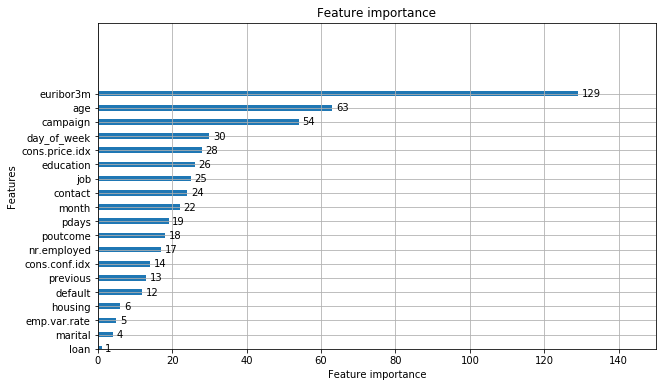

In [24]:
#Dimensionality reduction using feature importances
#features importance graph
ax = lgb.plot_importance(gbm, height = 0.4, 
                         max_num_features = 25,
                         ylabel='Features',
                         xlim = (0,150), ylim = (0,23), 
                         figsize = (10,6))
plt.show()

In [25]:
# For each feature of our dataset, the result of the following
# code snippet contains numbers of times a feature is used in a model.
sorted(gbm.feature_importances_,reverse=True)

[129, 63, 54, 30, 28, 26, 25, 24, 22, 19, 18, 17, 14, 13, 12, 6, 5, 4, 1]

In [19]:
# The code below aims to find where at least 85% 
temp = 0 
total = sum(gbm.feature_importances_)
for feature in sorted(gbm.feature_importances_, reverse=True):
    temp+=feature
    if temp/total >= 0.85:
        print(feature,temp/total) # stop when we 
        break

16 0.85625


In [20]:
from sklearn.metrics import auc, accuracy_score, roc_auc_score
y_pred_prob = gbm.predict_proba(X_test)[:, 1]
auc_roc_0=str(roc_auc_score(y_test, y_pred_prob)) # store AUC score without dimensionality reduction
print('AUC without dimensionality reduction: \n' + auc_roc_0)

AUC without dimensionality reduction: 
0.7977937429536279


In [26]:
#Drop features to reduce dimensionality to save training time and space

X = X.drop(['marital','housing','loan','emp.var.rate','previous','default','nr.employed'], axis=1)


In [27]:
print(X)

       age  job  education  contact  month  day_of_week  campaign  pdays  \
0       56    3          0        1      6            1         1    999   
1       57    7          3        1      6            1         1    999   
2       37    7          3        1      6            1         1    999   
3       40    0          1        1      6            1         1    999   
4       56    7          3        1      6            1         1    999   
5       45    7          2        1      6            1         1    999   
6       59    0          5        1      6            1         1    999   
7       41    1          7        1      6            1         1    999   
8       24    9          5        1      6            1         1    999   
9       25    7          3        1      6            1         1    999   
10      41    1          7        1      6            1         1    999   
11      25    7          3        1      6            1         1    999   
12      29  

In [28]:
# Remake our test/train set with our reduced dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=21)

reduc_estimator = lgb.LGBMClassifier(learning_rate = 0.125, metric = 'l1', 
                        n_estimators = 20, num_leaves = 38)

# Parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [x for x in range(20, 36, 2)],
    'learning_rate': [0.10, 0.125, 0.15, 0.175, 0.2]}

gridsearch = GridSearchCV(reduc_estimator, param_grid)

gridsearch.fit(X_train, y_train,
        eval_set = [(X_test, y_test)],
        eval_metric = ['auc', 'binary_logloss'],
        early_stopping_rounds = 5)
print('Best parameters found by grid search are:', gridsearch.best_params_)

C:\Users\barba\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


[1]	valid_0's auc: 0.782654	valid_0's binary_logloss: 0.330573	valid_0's l1: 0.194997
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.782692	valid_0's binary_logloss: 0.318298	valid_0's l1: 0.190841
[3]	valid_0's auc: 0.781235	valid_0's binary_logloss: 0.309467	valid_0's l1: 0.187189
[4]	valid_0's auc: 0.785108	valid_0's binary_logloss: 0.302506	valid_0's l1: 0.183779
[5]	valid_0's auc: 0.785779	valid_0's binary_logloss: 0.297177	valid_0's l1: 0.180737
[6]	valid_0's auc: 0.788015	valid_0's binary_logloss: 0.292988	valid_0's l1: 0.178046
[7]	valid_0's auc: 0.787269	valid_0's binary_logloss: 0.28969	valid_0's l1: 0.175658
[8]	valid_0's auc: 0.788741	valid_0's binary_logloss: 0.28681	valid_0's l1: 0.173403
[9]	valid_0's auc: 0.789503	valid_0's binary_logloss: 0.284758	valid_0's l1: 0.171536
[10]	valid_0's auc: 0.789659	valid_0's binary_logloss: 0.282806	valid_0's l1: 0.169596
[11]	valid_0's auc: 0.795524	valid_0's binary_logloss: 0.281144	valid_0's l1: 0.

[1]	valid_0's auc: 0.779353	valid_0's binary_logloss: 0.330866	valid_0's l1: 0.194944
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.783679	valid_0's binary_logloss: 0.318274	valid_0's l1: 0.190665
[3]	valid_0's auc: 0.784618	valid_0's binary_logloss: 0.309127	valid_0's l1: 0.186832
[4]	valid_0's auc: 0.785556	valid_0's binary_logloss: 0.30228	valid_0's l1: 0.183436
[5]	valid_0's auc: 0.787524	valid_0's binary_logloss: 0.297156	valid_0's l1: 0.180481
[6]	valid_0's auc: 0.787785	valid_0's binary_logloss: 0.293014	valid_0's l1: 0.177774
[7]	valid_0's auc: 0.789918	valid_0's binary_logloss: 0.289637	valid_0's l1: 0.175347
[8]	valid_0's auc: 0.789717	valid_0's binary_logloss: 0.286981	valid_0's l1: 0.173171
[9]	valid_0's auc: 0.791721	valid_0's binary_logloss: 0.284683	valid_0's l1: 0.171088
[10]	valid_0's auc: 0.793259	valid_0's binary_logloss: 0.282655	valid_0's l1: 0.169201
[11]	valid_0's auc: 0.796427	valid_0's binary_logloss: 0.280949	valid_0's l1: 0

[1]	valid_0's auc: 0.782654	valid_0's binary_logloss: 0.330573	valid_0's l1: 0.194997
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.782692	valid_0's binary_logloss: 0.318298	valid_0's l1: 0.190841
[3]	valid_0's auc: 0.781235	valid_0's binary_logloss: 0.309467	valid_0's l1: 0.187189
[4]	valid_0's auc: 0.785108	valid_0's binary_logloss: 0.302506	valid_0's l1: 0.183779
[5]	valid_0's auc: 0.785779	valid_0's binary_logloss: 0.297177	valid_0's l1: 0.180737
[6]	valid_0's auc: 0.788015	valid_0's binary_logloss: 0.292988	valid_0's l1: 0.178046
[7]	valid_0's auc: 0.787269	valid_0's binary_logloss: 0.28969	valid_0's l1: 0.175658
[8]	valid_0's auc: 0.788741	valid_0's binary_logloss: 0.28681	valid_0's l1: 0.173403
[9]	valid_0's auc: 0.789503	valid_0's binary_logloss: 0.284758	valid_0's l1: 0.171536
[10]	valid_0's auc: 0.789659	valid_0's binary_logloss: 0.282806	valid_0's l1: 0.169596
[11]	valid_0's auc: 0.795524	valid_0's binary_logloss: 0.281144	valid_0's l1: 0.

[1]	valid_0's auc: 0.765905	valid_0's binary_logloss: 0.330235	valid_0's l1: 0.194731
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.785917	valid_0's binary_logloss: 0.317157	valid_0's l1: 0.190293
[3]	valid_0's auc: 0.785899	valid_0's binary_logloss: 0.307813	valid_0's l1: 0.186388
[4]	valid_0's auc: 0.787999	valid_0's binary_logloss: 0.30091	valid_0's l1: 0.182891
[5]	valid_0's auc: 0.78984	valid_0's binary_logloss: 0.29541	valid_0's l1: 0.179765
[6]	valid_0's auc: 0.789907	valid_0's binary_logloss: 0.291378	valid_0's l1: 0.176983
[7]	valid_0's auc: 0.797691	valid_0's binary_logloss: 0.287382	valid_0's l1: 0.174366
[8]	valid_0's auc: 0.797993	valid_0's binary_logloss: 0.284552	valid_0's l1: 0.172039
[9]	valid_0's auc: 0.798991	valid_0's binary_logloss: 0.281923	valid_0's l1: 0.169876
[10]	valid_0's auc: 0.800344	valid_0's binary_logloss: 0.279815	valid_0's l1: 0.16801
[11]	valid_0's auc: 0.801844	valid_0's binary_logloss: 0.278079	valid_0's l1: 0.16

[1]	valid_0's auc: 0.779353	valid_0's binary_logloss: 0.330866	valid_0's l1: 0.194944
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.783679	valid_0's binary_logloss: 0.318274	valid_0's l1: 0.190665
[3]	valid_0's auc: 0.784618	valid_0's binary_logloss: 0.309127	valid_0's l1: 0.186832
[4]	valid_0's auc: 0.785556	valid_0's binary_logloss: 0.30228	valid_0's l1: 0.183436
[5]	valid_0's auc: 0.787524	valid_0's binary_logloss: 0.297156	valid_0's l1: 0.180481
[6]	valid_0's auc: 0.787785	valid_0's binary_logloss: 0.293014	valid_0's l1: 0.177774
[7]	valid_0's auc: 0.789918	valid_0's binary_logloss: 0.289637	valid_0's l1: 0.175347
[8]	valid_0's auc: 0.789717	valid_0's binary_logloss: 0.286981	valid_0's l1: 0.173171
[9]	valid_0's auc: 0.791721	valid_0's binary_logloss: 0.284683	valid_0's l1: 0.171088
[10]	valid_0's auc: 0.793259	valid_0's binary_logloss: 0.282655	valid_0's l1: 0.169201
[11]	valid_0's auc: 0.796427	valid_0's binary_logloss: 0.280949	valid_0's l1: 0

[1]	valid_0's auc: 0.782654	valid_0's binary_logloss: 0.330573	valid_0's l1: 0.194997
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.782692	valid_0's binary_logloss: 0.318298	valid_0's l1: 0.190841
[3]	valid_0's auc: 0.781235	valid_0's binary_logloss: 0.309467	valid_0's l1: 0.187189
[4]	valid_0's auc: 0.785108	valid_0's binary_logloss: 0.302506	valid_0's l1: 0.183779
[5]	valid_0's auc: 0.785779	valid_0's binary_logloss: 0.297177	valid_0's l1: 0.180737
[6]	valid_0's auc: 0.788015	valid_0's binary_logloss: 0.292988	valid_0's l1: 0.178046
[7]	valid_0's auc: 0.787269	valid_0's binary_logloss: 0.28969	valid_0's l1: 0.175658
[8]	valid_0's auc: 0.788741	valid_0's binary_logloss: 0.28681	valid_0's l1: 0.173403
[9]	valid_0's auc: 0.789503	valid_0's binary_logloss: 0.284758	valid_0's l1: 0.171536
[10]	valid_0's auc: 0.789659	valid_0's binary_logloss: 0.282806	valid_0's l1: 0.169596
[11]	valid_0's auc: 0.795524	valid_0's binary_logloss: 0.281144	valid_0's l1: 0.

[1]	valid_0's auc: 0.765905	valid_0's binary_logloss: 0.325375	valid_0's l1: 0.193435
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.785977	valid_0's binary_logloss: 0.311039	valid_0's l1: 0.188063
[3]	valid_0's auc: 0.786707	valid_0's binary_logloss: 0.301686	valid_0's l1: 0.183529
[4]	valid_0's auc: 0.787096	valid_0's binary_logloss: 0.294922	valid_0's l1: 0.17951
[5]	valid_0's auc: 0.789009	valid_0's binary_logloss: 0.289838	valid_0's l1: 0.176004
[6]	valid_0's auc: 0.794588	valid_0's binary_logloss: 0.285664	valid_0's l1: 0.172889
[7]	valid_0's auc: 0.798813	valid_0's binary_logloss: 0.282284	valid_0's l1: 0.170225
[8]	valid_0's auc: 0.798893	valid_0's binary_logloss: 0.279805	valid_0's l1: 0.16791
[9]	valid_0's auc: 0.79995	valid_0's binary_logloss: 0.277749	valid_0's l1: 0.165849
[10]	valid_0's auc: 0.799755	valid_0's binary_logloss: 0.27629	valid_0's l1: 0.164025
[11]	valid_0's auc: 0.799982	valid_0's binary_logloss: 0.274903	valid_0's l1: 0.16

[1]	valid_0's auc: 0.782654	valid_0's binary_logloss: 0.325797	valid_0's l1: 0.193788
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.77922	valid_0's binary_logloss: 0.312499	valid_0's l1: 0.188813
[3]	valid_0's auc: 0.783113	valid_0's binary_logloss: 0.303106	valid_0's l1: 0.184411
[4]	valid_0's auc: 0.78443	valid_0's binary_logloss: 0.296746	valid_0's l1: 0.180635
[5]	valid_0's auc: 0.786959	valid_0's binary_logloss: 0.291654	valid_0's l1: 0.177256
[6]	valid_0's auc: 0.788057	valid_0's binary_logloss: 0.28767	valid_0's l1: 0.174322
[7]	valid_0's auc: 0.789241	valid_0's binary_logloss: 0.2848	valid_0's l1: 0.171755
[8]	valid_0's auc: 0.796119	valid_0's binary_logloss: 0.282042	valid_0's l1: 0.169557
[9]	valid_0's auc: 0.794674	valid_0's binary_logloss: 0.280437	valid_0's l1: 0.167557
[10]	valid_0's auc: 0.797128	valid_0's binary_logloss: 0.278804	valid_0's l1: 0.165794
[11]	valid_0's auc: 0.796876	valid_0's binary_logloss: 0.277781	valid_0's l1: 0.164

[1]	valid_0's auc: 0.765905	valid_0's binary_logloss: 0.325375	valid_0's l1: 0.193435
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.785977	valid_0's binary_logloss: 0.311039	valid_0's l1: 0.188063
[3]	valid_0's auc: 0.786707	valid_0's binary_logloss: 0.301686	valid_0's l1: 0.183529
[4]	valid_0's auc: 0.787096	valid_0's binary_logloss: 0.294922	valid_0's l1: 0.17951
[5]	valid_0's auc: 0.789009	valid_0's binary_logloss: 0.289838	valid_0's l1: 0.176004
[6]	valid_0's auc: 0.794588	valid_0's binary_logloss: 0.285664	valid_0's l1: 0.172889
[7]	valid_0's auc: 0.798813	valid_0's binary_logloss: 0.282284	valid_0's l1: 0.170225
[8]	valid_0's auc: 0.798893	valid_0's binary_logloss: 0.279805	valid_0's l1: 0.16791
[9]	valid_0's auc: 0.79995	valid_0's binary_logloss: 0.277749	valid_0's l1: 0.165849
[10]	valid_0's auc: 0.799755	valid_0's binary_logloss: 0.27629	valid_0's l1: 0.164025
[11]	valid_0's auc: 0.799982	valid_0's binary_logloss: 0.274903	valid_0's l1: 0.16

[1]	valid_0's auc: 0.779353	valid_0's binary_logloss: 0.326145	valid_0's l1: 0.193716
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.783223	valid_0's binary_logloss: 0.312544	valid_0's l1: 0.188624
[3]	valid_0's auc: 0.783278	valid_0's binary_logloss: 0.303075	valid_0's l1: 0.184194
[4]	valid_0's auc: 0.783426	valid_0's binary_logloss: 0.296869	valid_0's l1: 0.180434
[5]	valid_0's auc: 0.785072	valid_0's binary_logloss: 0.291875	valid_0's l1: 0.177058
[6]	valid_0's auc: 0.788818	valid_0's binary_logloss: 0.288112	valid_0's l1: 0.174141
[7]	valid_0's auc: 0.787674	valid_0's binary_logloss: 0.285245	valid_0's l1: 0.171501
[8]	valid_0's auc: 0.790286	valid_0's binary_logloss: 0.283008	valid_0's l1: 0.169225
[9]	valid_0's auc: 0.793892	valid_0's binary_logloss: 0.28097	valid_0's l1: 0.167282
[10]	valid_0's auc: 0.796974	valid_0's binary_logloss: 0.279258	valid_0's l1: 0.165367
[11]	valid_0's auc: 0.799293	valid_0's binary_logloss: 0.27799	valid_0's l1: 0.

[1]	valid_0's auc: 0.782654	valid_0's binary_logloss: 0.325797	valid_0's l1: 0.193788
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.77922	valid_0's binary_logloss: 0.312499	valid_0's l1: 0.188813
[3]	valid_0's auc: 0.783113	valid_0's binary_logloss: 0.303106	valid_0's l1: 0.184411
[4]	valid_0's auc: 0.78443	valid_0's binary_logloss: 0.296746	valid_0's l1: 0.180635
[5]	valid_0's auc: 0.786959	valid_0's binary_logloss: 0.291654	valid_0's l1: 0.177256
[6]	valid_0's auc: 0.788057	valid_0's binary_logloss: 0.28767	valid_0's l1: 0.174322
[7]	valid_0's auc: 0.789241	valid_0's binary_logloss: 0.2848	valid_0's l1: 0.171755
[8]	valid_0's auc: 0.796119	valid_0's binary_logloss: 0.282042	valid_0's l1: 0.169557
[9]	valid_0's auc: 0.794674	valid_0's binary_logloss: 0.280437	valid_0's l1: 0.167557
[10]	valid_0's auc: 0.797128	valid_0's binary_logloss: 0.278804	valid_0's l1: 0.165794
[11]	valid_0's auc: 0.796876	valid_0's binary_logloss: 0.277781	valid_0's l1: 0.164

[1]	valid_0's auc: 0.765905	valid_0's binary_logloss: 0.325375	valid_0's l1: 0.193435
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.785977	valid_0's binary_logloss: 0.311039	valid_0's l1: 0.188063
[3]	valid_0's auc: 0.786707	valid_0's binary_logloss: 0.301686	valid_0's l1: 0.183529
[4]	valid_0's auc: 0.787096	valid_0's binary_logloss: 0.294922	valid_0's l1: 0.17951
[5]	valid_0's auc: 0.789009	valid_0's binary_logloss: 0.289838	valid_0's l1: 0.176004
[6]	valid_0's auc: 0.794588	valid_0's binary_logloss: 0.285664	valid_0's l1: 0.172889
[7]	valid_0's auc: 0.798813	valid_0's binary_logloss: 0.282284	valid_0's l1: 0.170225
[8]	valid_0's auc: 0.798893	valid_0's binary_logloss: 0.279805	valid_0's l1: 0.16791
[9]	valid_0's auc: 0.79995	valid_0's binary_logloss: 0.277749	valid_0's l1: 0.165849
[10]	valid_0's auc: 0.799755	valid_0's binary_logloss: 0.27629	valid_0's l1: 0.164025
[11]	valid_0's auc: 0.799982	valid_0's binary_logloss: 0.274903	valid_0's l1: 0.16

[1]	valid_0's auc: 0.779353	valid_0's binary_logloss: 0.321628	valid_0's l1: 0.192478
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.783236	valid_0's binary_logloss: 0.307372	valid_0's l1: 0.186616
[3]	valid_0's auc: 0.783823	valid_0's binary_logloss: 0.298037	valid_0's l1: 0.181603
[4]	valid_0's auc: 0.785901	valid_0's binary_logloss: 0.29208	valid_0's l1: 0.177529
[5]	valid_0's auc: 0.788811	valid_0's binary_logloss: 0.287542	valid_0's l1: 0.174002
[6]	valid_0's auc: 0.787825	valid_0's binary_logloss: 0.28441	valid_0's l1: 0.170866
[7]	valid_0's auc: 0.791446	valid_0's binary_logloss: 0.28183	valid_0's l1: 0.168192
[8]	valid_0's auc: 0.795378	valid_0's binary_logloss: 0.27984	valid_0's l1: 0.165996
[9]	valid_0's auc: 0.798036	valid_0's binary_logloss: 0.277983	valid_0's l1: 0.164041
[10]	valid_0's auc: 0.798302	valid_0's binary_logloss: 0.277007	valid_0's l1: 0.16233
[11]	valid_0's auc: 0.79943	valid_0's binary_logloss: 0.276043	valid_0's l1: 0.1609

[8]	valid_0's auc: 0.791487	valid_0's binary_logloss: 0.27953	valid_0's l1: 0.166542
[9]	valid_0's auc: 0.793077	valid_0's binary_logloss: 0.278257	valid_0's l1: 0.164725
[10]	valid_0's auc: 0.794707	valid_0's binary_logloss: 0.27709	valid_0's l1: 0.163095
[11]	valid_0's auc: 0.79493	valid_0's binary_logloss: 0.276179	valid_0's l1: 0.16168
[12]	valid_0's auc: 0.794317	valid_0's binary_logloss: 0.275501	valid_0's l1: 0.16041
[13]	valid_0's auc: 0.797378	valid_0's binary_logloss: 0.274437	valid_0's l1: 0.159256
[14]	valid_0's auc: 0.796501	valid_0's binary_logloss: 0.273968	valid_0's l1: 0.158283
[15]	valid_0's auc: 0.79624	valid_0's binary_logloss: 0.273945	valid_0's l1: 0.157502
[16]	valid_0's auc: 0.795309	valid_0's binary_logloss: 0.273996	valid_0's l1: 0.156952
[17]	valid_0's auc: 0.798229	valid_0's binary_logloss: 0.273446	valid_0's l1: 0.156301
[18]	valid_0's auc: 0.798319	valid_0's binary_logloss: 0.273157	valid_0's l1: 0.155824
[19]	valid_0's auc: 0.798258	valid_0's binary_loglo

[4]	valid_0's auc: 0.785901	valid_0's binary_logloss: 0.29208	valid_0's l1: 0.177529
[5]	valid_0's auc: 0.788811	valid_0's binary_logloss: 0.287542	valid_0's l1: 0.174002
[6]	valid_0's auc: 0.787825	valid_0's binary_logloss: 0.28441	valid_0's l1: 0.170866
[7]	valid_0's auc: 0.791446	valid_0's binary_logloss: 0.28183	valid_0's l1: 0.168192
[8]	valid_0's auc: 0.795378	valid_0's binary_logloss: 0.27984	valid_0's l1: 0.165996
[9]	valid_0's auc: 0.798036	valid_0's binary_logloss: 0.277983	valid_0's l1: 0.164041
[10]	valid_0's auc: 0.798302	valid_0's binary_logloss: 0.277007	valid_0's l1: 0.16233
[11]	valid_0's auc: 0.79943	valid_0's binary_logloss: 0.276043	valid_0's l1: 0.160953
[12]	valid_0's auc: 0.798857	valid_0's binary_logloss: 0.275545	valid_0's l1: 0.159721
[13]	valid_0's auc: 0.799176	valid_0's binary_logloss: 0.274861	valid_0's l1: 0.15849
[14]	valid_0's auc: 0.800407	valid_0's binary_logloss: 0.274247	valid_0's l1: 0.157528
[15]	valid_0's auc: 0.799219	valid_0's binary_logloss: 0

[1]	valid_0's auc: 0.765905	valid_0's binary_logloss: 0.320729	valid_0's l1: 0.192124
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.782381	valid_0's binary_logloss: 0.306489	valid_0's l1: 0.186111
[3]	valid_0's auc: 0.786383	valid_0's binary_logloss: 0.297018	valid_0's l1: 0.181013
[4]	valid_0's auc: 0.788693	valid_0's binary_logloss: 0.290452	valid_0's l1: 0.176647
[5]	valid_0's auc: 0.797734	valid_0's binary_logloss: 0.285148	valid_0's l1: 0.172852
[6]	valid_0's auc: 0.799169	valid_0's binary_logloss: 0.281638	valid_0's l1: 0.1697
[7]	valid_0's auc: 0.800101	valid_0's binary_logloss: 0.278738	valid_0's l1: 0.166941
[8]	valid_0's auc: 0.800326	valid_0's binary_logloss: 0.276786	valid_0's l1: 0.164749
[9]	valid_0's auc: 0.801476	valid_0's binary_logloss: 0.275121	valid_0's l1: 0.162695
[10]	valid_0's auc: 0.801134	valid_0's binary_logloss: 0.273933	valid_0's l1: 0.160957
[11]	valid_0's auc: 0.801789	valid_0's binary_logloss: 0.273213	valid_0's l1: 0.

[1]	valid_0's auc: 0.782654	valid_0's binary_logloss: 0.321234	valid_0's l1: 0.192568
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.781606	valid_0's binary_logloss: 0.307442	valid_0's l1: 0.186811
[3]	valid_0's auc: 0.786322	valid_0's binary_logloss: 0.298166	valid_0's l1: 0.181888
[4]	valid_0's auc: 0.78814	valid_0's binary_logloss: 0.291689	valid_0's l1: 0.177703
[5]	valid_0's auc: 0.787252	valid_0's binary_logloss: 0.287321	valid_0's l1: 0.174277
[6]	valid_0's auc: 0.789275	valid_0's binary_logloss: 0.284025	valid_0's l1: 0.171305
[7]	valid_0's auc: 0.790637	valid_0's binary_logloss: 0.281387	valid_0's l1: 0.168649
[8]	valid_0's auc: 0.791487	valid_0's binary_logloss: 0.27953	valid_0's l1: 0.166542
[9]	valid_0's auc: 0.793077	valid_0's binary_logloss: 0.278257	valid_0's l1: 0.164725
[10]	valid_0's auc: 0.794707	valid_0's binary_logloss: 0.27709	valid_0's l1: 0.163095
[11]	valid_0's auc: 0.79493	valid_0's binary_logloss: 0.276179	valid_0's l1: 0.16

[9]	valid_0's auc: 0.800528	valid_0's binary_logloss: 0.273384	valid_0's l1: 0.159786
[10]	valid_0's auc: 0.800734	valid_0's binary_logloss: 0.272418	valid_0's l1: 0.158333
[11]	valid_0's auc: 0.801649	valid_0's binary_logloss: 0.271812	valid_0's l1: 0.157002
[12]	valid_0's auc: 0.800786	valid_0's binary_logloss: 0.271297	valid_0's l1: 0.155741
[13]	valid_0's auc: 0.802039	valid_0's binary_logloss: 0.27086	valid_0's l1: 0.154689
[14]	valid_0's auc: 0.80257	valid_0's binary_logloss: 0.270136	valid_0's l1: 0.153614
[15]	valid_0's auc: 0.802454	valid_0's binary_logloss: 0.270217	valid_0's l1: 0.152966
[16]	valid_0's auc: 0.802296	valid_0's binary_logloss: 0.269912	valid_0's l1: 0.152406
[17]	valid_0's auc: 0.800991	valid_0's binary_logloss: 0.269857	valid_0's l1: 0.151988
[18]	valid_0's auc: 0.800701	valid_0's binary_logloss: 0.269917	valid_0's l1: 0.151855
[19]	valid_0's auc: 0.802912	valid_0's binary_logloss: 0.269374	valid_0's l1: 0.151478
[20]	valid_0's auc: 0.80299	valid_0's binary_l

[12]	valid_0's auc: 0.800786	valid_0's binary_logloss: 0.271297	valid_0's l1: 0.155741
[13]	valid_0's auc: 0.802039	valid_0's binary_logloss: 0.27086	valid_0's l1: 0.154689
[14]	valid_0's auc: 0.80257	valid_0's binary_logloss: 0.270136	valid_0's l1: 0.153614
[15]	valid_0's auc: 0.802454	valid_0's binary_logloss: 0.270217	valid_0's l1: 0.152966
[16]	valid_0's auc: 0.802296	valid_0's binary_logloss: 0.269912	valid_0's l1: 0.152406
[17]	valid_0's auc: 0.800991	valid_0's binary_logloss: 0.269857	valid_0's l1: 0.151988
[18]	valid_0's auc: 0.800701	valid_0's binary_logloss: 0.269917	valid_0's l1: 0.151855
[19]	valid_0's auc: 0.802912	valid_0's binary_logloss: 0.269374	valid_0's l1: 0.151478
[20]	valid_0's auc: 0.80299	valid_0's binary_logloss: 0.269367	valid_0's l1: 0.151207
[21]	valid_0's auc: 0.804191	valid_0's binary_logloss: 0.269424	valid_0's l1: 0.151092
[22]	valid_0's auc: 0.802913	valid_0's binary_logloss: 0.269805	valid_0's l1: 0.150964
[23]	valid_0's auc: 0.802863	valid_0's binary_

[12]	valid_0's auc: 0.799868	valid_0's binary_logloss: 0.273786	valid_0's l1: 0.158155
[13]	valid_0's auc: 0.797879	valid_0's binary_logloss: 0.27402	valid_0's l1: 0.157368
[14]	valid_0's auc: 0.797906	valid_0's binary_logloss: 0.273711	valid_0's l1: 0.156464
Early stopping, best iteration is:
[9]	valid_0's auc: 0.801139	valid_0's binary_logloss: 0.275543	valid_0's l1: 0.161812
[1]	valid_0's auc: 0.765905	valid_0's binary_logloss: 0.31631	valid_0's l1: 0.190799
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.782855	valid_0's binary_logloss: 0.301573	valid_0's l1: 0.184021
[3]	valid_0's auc: 0.78851	valid_0's binary_logloss: 0.292069	valid_0's l1: 0.178382
[4]	valid_0's auc: 0.790203	valid_0's binary_logloss: 0.28647	valid_0's l1: 0.173877
[5]	valid_0's auc: 0.79794	valid_0's binary_logloss: 0.281639	valid_0's l1: 0.169979
[6]	valid_0's auc: 0.79862	valid_0's binary_logloss: 0.278202	valid_0's l1: 0.166601
[7]	valid_0's auc: 0.800176	valid_0's binary_lo

[8]	valid_0's auc: 0.799951	valid_0's binary_logloss: 0.276402	valid_0's l1: 0.163512
[9]	valid_0's auc: 0.801139	valid_0's binary_logloss: 0.275543	valid_0's l1: 0.161812
[10]	valid_0's auc: 0.801026	valid_0's binary_logloss: 0.274851	valid_0's l1: 0.160417
[11]	valid_0's auc: 0.800807	valid_0's binary_logloss: 0.274115	valid_0's l1: 0.15916
[12]	valid_0's auc: 0.799868	valid_0's binary_logloss: 0.273786	valid_0's l1: 0.158155
[13]	valid_0's auc: 0.797879	valid_0's binary_logloss: 0.27402	valid_0's l1: 0.157368
[14]	valid_0's auc: 0.797906	valid_0's binary_logloss: 0.273711	valid_0's l1: 0.156464
Early stopping, best iteration is:
[9]	valid_0's auc: 0.801139	valid_0's binary_logloss: 0.275543	valid_0's l1: 0.161812
[1]	valid_0's auc: 0.765905	valid_0's binary_logloss: 0.31631	valid_0's l1: 0.190799
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.782855	valid_0's binary_logloss: 0.301573	valid_0's l1: 0.184021
[3]	valid_0's auc: 0.78851	valid_0's binar

[10]	valid_0's auc: 0.79341	valid_0's binary_logloss: 0.274872	valid_0's l1: 0.15864
[11]	valid_0's auc: 0.793111	valid_0's binary_logloss: 0.274487	valid_0's l1: 0.157639
[12]	valid_0's auc: 0.796676	valid_0's binary_logloss: 0.273818	valid_0's l1: 0.156773
[13]	valid_0's auc: 0.797628	valid_0's binary_logloss: 0.273647	valid_0's l1: 0.155998
[14]	valid_0's auc: 0.798767	valid_0's binary_logloss: 0.273105	valid_0's l1: 0.15525
[15]	valid_0's auc: 0.79798	valid_0's binary_logloss: 0.273207	valid_0's l1: 0.154909
[16]	valid_0's auc: 0.798416	valid_0's binary_logloss: 0.273252	valid_0's l1: 0.15451
[17]	valid_0's auc: 0.798504	valid_0's binary_logloss: 0.273123	valid_0's l1: 0.154267
[18]	valid_0's auc: 0.798791	valid_0's binary_logloss: 0.273066	valid_0's l1: 0.153888
[19]	valid_0's auc: 0.799234	valid_0's binary_logloss: 0.273015	valid_0's l1: 0.153834
[20]	valid_0's auc: 0.798259	valid_0's binary_logloss: 0.273119	valid_0's l1: 0.153625
Did not meet early stopping. Best iteration is:


[6]	valid_0's auc: 0.790331	valid_0's binary_logloss: 0.279672	valid_0's l1: 0.165472
[7]	valid_0's auc: 0.795257	valid_0's binary_logloss: 0.277339	valid_0's l1: 0.16286
[8]	valid_0's auc: 0.795628	valid_0's binary_logloss: 0.276251	valid_0's l1: 0.160901
[9]	valid_0's auc: 0.796102	valid_0's binary_logloss: 0.275548	valid_0's l1: 0.159221
[10]	valid_0's auc: 0.796252	valid_0's binary_logloss: 0.275085	valid_0's l1: 0.157993
[11]	valid_0's auc: 0.798444	valid_0's binary_logloss: 0.274031	valid_0's l1: 0.156671
[12]	valid_0's auc: 0.800483	valid_0's binary_logloss: 0.27367	valid_0's l1: 0.155725
[13]	valid_0's auc: 0.800252	valid_0's binary_logloss: 0.273651	valid_0's l1: 0.155124
[14]	valid_0's auc: 0.800207	valid_0's binary_logloss: 0.273334	valid_0's l1: 0.1544
[15]	valid_0's auc: 0.800034	valid_0's binary_logloss: 0.273763	valid_0's l1: 0.154251
[16]	valid_0's auc: 0.798583	valid_0's binary_logloss: 0.274063	valid_0's l1: 0.153993
[17]	valid_0's auc: 0.798956	valid_0's binary_loglo

[23]	valid_0's auc: 0.796786	valid_0's binary_logloss: 0.273471	valid_0's l1: 0.153418
[24]	valid_0's auc: 0.796891	valid_0's binary_logloss: 0.273413	valid_0's l1: 0.153305
Early stopping, best iteration is:
[19]	valid_0's auc: 0.799234	valid_0's binary_logloss: 0.273015	valid_0's l1: 0.153834
[1]	valid_0's auc: 0.765905	valid_0's binary_logloss: 0.312133	valid_0's l1: 0.189464
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.784842	valid_0's binary_logloss: 0.297499	valid_0's l1: 0.182001
[3]	valid_0's auc: 0.787987	valid_0's binary_logloss: 0.288517	valid_0's l1: 0.17598
[4]	valid_0's auc: 0.799826	valid_0's binary_logloss: 0.282252	valid_0's l1: 0.171102
[5]	valid_0's auc: 0.799794	valid_0's binary_logloss: 0.278474	valid_0's l1: 0.167119
[6]	valid_0's auc: 0.802385	valid_0's binary_logloss: 0.275873	valid_0's l1: 0.16396
[7]	valid_0's auc: 0.80395	valid_0's binary_logloss: 0.273694	valid_0's l1: 0.161135
[8]	valid_0's auc: 0.803227	valid_0's binary

[13]	valid_0's auc: 0.797628	valid_0's binary_logloss: 0.273647	valid_0's l1: 0.155998
[14]	valid_0's auc: 0.798767	valid_0's binary_logloss: 0.273105	valid_0's l1: 0.15525
[15]	valid_0's auc: 0.79798	valid_0's binary_logloss: 0.273207	valid_0's l1: 0.154909
[16]	valid_0's auc: 0.798416	valid_0's binary_logloss: 0.273252	valid_0's l1: 0.15451
[17]	valid_0's auc: 0.798504	valid_0's binary_logloss: 0.273123	valid_0's l1: 0.154267
[18]	valid_0's auc: 0.798791	valid_0's binary_logloss: 0.273066	valid_0's l1: 0.153888
[19]	valid_0's auc: 0.799234	valid_0's binary_logloss: 0.273015	valid_0's l1: 0.153834
[20]	valid_0's auc: 0.798259	valid_0's binary_logloss: 0.273119	valid_0's l1: 0.153625
[21]	valid_0's auc: 0.79849	valid_0's binary_logloss: 0.272886	valid_0's l1: 0.153242
[22]	valid_0's auc: 0.797574	valid_0's binary_logloss: 0.273242	valid_0's l1: 0.15343
[23]	valid_0's auc: 0.796786	valid_0's binary_logloss: 0.273471	valid_0's l1: 0.153418
[24]	valid_0's auc: 0.796891	valid_0's binary_lo

[1]	valid_0's auc: 0.779353	valid_0's binary_logloss: 0.313259	valid_0's l1: 0.189978
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.783574	valid_0's binary_logloss: 0.29872	valid_0's l1: 0.182715
[3]	valid_0's auc: 0.786033	valid_0's binary_logloss: 0.29078	valid_0's l1: 0.177184
[4]	valid_0's auc: 0.788221	valid_0's binary_logloss: 0.285646	valid_0's l1: 0.172393
[5]	valid_0's auc: 0.789186	valid_0's binary_logloss: 0.282093	valid_0's l1: 0.168432
[6]	valid_0's auc: 0.790331	valid_0's binary_logloss: 0.279672	valid_0's l1: 0.165472
[7]	valid_0's auc: 0.795257	valid_0's binary_logloss: 0.277339	valid_0's l1: 0.16286
[8]	valid_0's auc: 0.795628	valid_0's binary_logloss: 0.276251	valid_0's l1: 0.160901
[9]	valid_0's auc: 0.796102	valid_0's binary_logloss: 0.275548	valid_0's l1: 0.159221
[10]	valid_0's auc: 0.796252	valid_0's binary_logloss: 0.275085	valid_0's l1: 0.157993
[11]	valid_0's auc: 0.798444	valid_0's binary_logloss: 0.274031	valid_0's l1: 0.1

In [29]:
gbm = lgb.LGBMClassifier(learning_rate = 0.15, metric = 'l1', 
                        n_estimators = 20)
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric=['auc', 'binary_logloss'],
early_stopping_rounds=5)

[1]	valid_0's auc: 0.783366	valid_0's binary_logloss: 0.321751	valid_0's l1: 0.192525
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.783984	valid_0's binary_logloss: 0.307403	valid_0's l1: 0.186573
[3]	valid_0's auc: 0.785909	valid_0's binary_logloss: 0.298048	valid_0's l1: 0.181617
[4]	valid_0's auc: 0.788834	valid_0's binary_logloss: 0.291544	valid_0's l1: 0.177389
[5]	valid_0's auc: 0.790206	valid_0's binary_logloss: 0.287032	valid_0's l1: 0.17389
[6]	valid_0's auc: 0.795838	valid_0's binary_logloss: 0.283031	valid_0's l1: 0.17075
[7]	valid_0's auc: 0.795765	valid_0's binary_logloss: 0.280275	valid_0's l1: 0.167976
[8]	valid_0's auc: 0.797283	valid_0's binary_logloss: 0.278101	valid_0's l1: 0.165772
[9]	valid_0's auc: 0.798372	valid_0's binary_logloss: 0.276447	valid_0's l1: 0.163742
[10]	valid_0's auc: 0.798334	valid_0's binary_logloss: 0.275193	valid_0's l1: 0.161892
[11]	valid_0's auc: 0.798831	valid_0's binary_logloss: 0.274343	valid_0's l1: 0.

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.15, max_depth=-1,
        metric='l1', min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=20, n_jobs=-1, num_leaves=31,
        objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0)

In [30]:
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
print('The accuracy of prediction is:', accuracy_score(y_test, y_pred))
print('The roc_auc_score of prediction is:', roc_auc_score(y_test, y_pred))
print('The null acccuracy is:', max(y_test.mean(), 1 - y_test.mean()))

The accuracy of prediction is: 0.9041029376062151
The roc_auc_score of prediction is: 0.6102170579088904
The null acccuracy is: 0.8875940762320952


In [31]:
y_pred_prob = gbm.predict_proba(X_test)[:, 1]
y_pred_prob

array([0.07632906, 0.02980122, 0.04506656, ..., 0.12342936, 0.12026791,
       0.06087949])

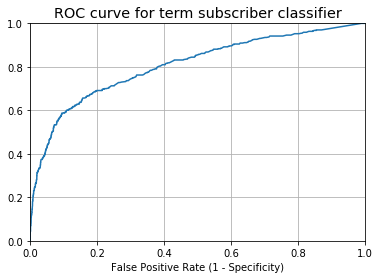

In [32]:
from sklearn.metrics import auc, accuracy_score, roc_auc_score, roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for term subscriber classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.grid(True)

In [33]:
auc_roc_1 = str(roc_auc_score(y_test, y_pred_prob))
print('AUC with dimensionality reduction: \n' + auc_roc_1)
print('AUC without dimensionality reduction: \n' + auc_roc_0)

AUC with dimensionality reduction: 
0.8066609047643803
AUC without dimensionality reduction: 
0.7977937429536279


In [34]:
from sklearn import metrics
print(metrics.confusion_matrix(y_test, y_pred))

#Basic terminology

#True Positives (TP): we correctly predicted that they would default.
#262
#True Negatives (TN): we correctly predicted that they won't default.
#3538
#False Positives (FP): we incorrectly predicted that they did default.
#118
#Falsely predict positive
#Type I error
#False Negatives (FN): we incorrectly predicted that they didn't default.
#201
#Falsely predict negative
#Type II error

[[3617   39]
 [ 356  107]]


In [35]:
score = gbm.score(X_test, y_test)
print(score)

0.9041029376062151
